# Project 5: Ensemble Models on Wine Quality

**Name:** Saratchandra Golla    
**Date:** November 15, 2025

**Introduction:**   
This project explores the use of ensemble machine learning models to classify the quality of red wine using physicochemical properties from the UCI Wine Quality Dataset. Ensemble methods, which combine multiple models, are powerful tools for improving predictive performance by reducing overfitting and enhancing generalization . The goal is to compare the performance of selected ensemble models and determine the best approach for this multi-class classification problem.

## Imports

We import all necessary libraries for data loading, preprocessing, model building (including ensemble methods), cross-validation, and evaluation.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensemble Models
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)
# Base Estimators for Voting and Bagging
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Utilities and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Set random seed for reproducibility
RANDOM_STATE = 42

## Section 1. Load and Inspect the Data
We load the Red Wine Quality Dataset. The original dataset contains 11 physicochemical features and a quality target variable . We use a semicolon (;) as a separator for the CSV file

In [13]:
# Load the wine quality dataset
try:
    df = pd.read_csv("winequality-red.csv", sep=";")
except FileNotFoundError:
    print("Error: 'winequality-red.csv' not found. Please ensure the file is in the same directory.")
    df = None # Handle case where file is missing

if df is not None:
    print("--- Wine Quality Dataset Info ---")
    df.info()
    print("\n--- Wine Quality Dataset Head ---")
    print(df.head())
    print(f"\nDataset loaded with {len(df)} samples and 12 columns (11 features + quality).")

--- Wine Quality Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

--- Wine Quality Dataset Head ---
   fixed acidity  volatile acidity  citric acid  residual

## Section 2. Prepare the Data
The original quality target variable is an integer score from 0 to 10. For a more practical classification task, we simplify this into three categorical levels: low (quality $\le 4$), medium (quality $\le 6$), and high (quality $\ge 7$) 

We create two new columns:
1. **quality_label:** a categorical string (low, medium, high)
2. **quality_numeric:** a numeric encoding of the label ($0=$ low, $1=$ medium, $2=$ high)

In [14]:
if df is not None:
    # 1. Helper function to map quality score to a string label
    def quality_to_label(q):
        """Return the quality label (low, medium, high) based on the quality score q."""
        if q <= 4:
            return "low"
        elif q <= 6:
            return "medium"
        else: # q >= 7
            return "high"
    
    # Apply the function to create the new label column
    df["quality_label"] = df["quality"].apply(quality_to_label)

    # 2. Helper function to map quality score to a numeric target
    def quality_to_number(q):
        """Return the numeric quality target (0=low, 1=medium, 2=high)."""
        if q <= 4:
            return 0
        elif q <= 6:
            return 1
        else: # q >= 7
            return 2
            
    # Apply the function to create the numeric target column
    df["quality_numeric"] = df["quality"].apply(quality_to_number)
    
    print("\n--- Data Preparation Complete ---")
    print(df[['quality', 'quality_label', 'quality_numeric']].head())
    print("\nDistribution of the new target variable:")
    print(df['quality_label'].value_counts())


--- Data Preparation Complete ---
   quality quality_label  quality_numeric
0        5        medium                1
1        5        medium                1
2        5        medium                1
3        6        medium                1
4        5        medium                1

Distribution of the new target variable:
quality_label
medium    1319
high       217
low         63
Name: count, dtype: int64


## Section 3. Feature Selection and Justification
We define the feature set (X) to include all physicochemical columns and the target variable (y) as the newly created quality_numeric column . We justify excluding the original quality and the new categorical columns (quality_label and quality_numeric) from the input features, as they are either the target itself or a direct transformation of the target, and would cause data leakage.

In [15]:
if df is not None:
    # Features (x): all physicochemical columns
    x = df.drop(columns=["quality", "quality_label", "quality_numeric"])

    # Target (y): the new numeric quality category
    y = df["quality_numeric"]

    print("\n--- Feature and Target Shape ---")
    print(f"Features (x) shape: {x.shape}")
    print(f"Target (y) shape: {y.shape}")


--- Feature and Target Shape ---
Features (x) shape: (1599, 11)
Target (y) shape: (1599,)


## Section 4. Split the Data into Train and Test
The data is split into 80% for training and 20% for testing using train_test_split. We use stratify=y to ensure that the class proportions (low, medium, high) are preserved in both the training and testing sets, which is important for imbalanced datasets.

In [16]:
if df is not None:
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    print("\n--- Data Split Complete ---")
    print(f"x_train shape: {x_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_train class distribution:\n{y_train.value_counts(normalize=True)}")
    print(f"y_test class distribution:\n{y_test.value_counts(normalize=True)}")


--- Data Split Complete ---
x_train shape: (1279, 11)
x_test shape: (320, 11)
y_train class distribution:
quality_numeric
1    0.824863
2    0.136044
0    0.039093
Name: proportion, dtype: float64
y_test class distribution:
quality_numeric
1    0.825000
2    0.134375
0    0.040625
Name: proportion, dtype: float64


## Section 5. Evaluate Model Performance
We define a helper function evaluate_model to streamline the training, prediction, and metric calculation process for consistency across models. We will focus on Train Accuracy, Test Accuracy, Train F1 Score, and Test F1 Score (weighted average) .

In [17]:
# Helper function to train and evaluate models
def evaluate_model(name, model, x_train, y_train, x_test, y_test, results):
    """Trains a model, calculates performance metrics, and appends to results list."""
    
    # Train the model
    model.fit(x_train, y_train)
    # Make predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    
    # Print results
    print(f"\n{name} Results")
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['low', 'medium', 'high'], 
                yticklabels=['low', 'medium', 'high'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Append to results list
    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Train F1": train_f1,
            "Test F1": test_f1
        }
    )

# Initialize results list
results = []

### Section 5.1 - Model 1: Random Forest (100)
A strong, parallel ensemble of 100 decision trees.


--- Evaluating Model 1: Random Forest (100) ---

Random Forest (100) Results
Train Accuracy: 1.0000, Test Accuracy: 0.8875
Train F1 Score: 1.0000, Test F1 Score: 0.8661


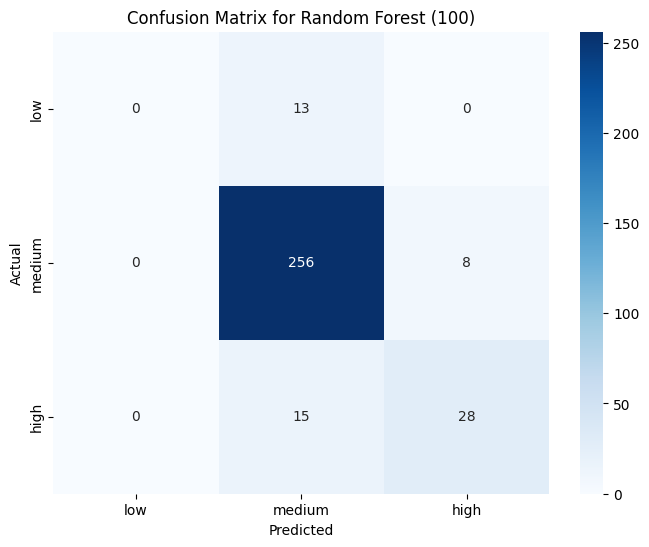

In [18]:
# 1. Random Forest (100)
print("\n--- Evaluating Model 1: Random Forest (100) ---")
if df is not None:
    evaluate_model(
        "Random Forest (100)",
        RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
        x_train,
        y_train,
        x_test,
        y_test,
        results,
    )

### Section 5.2 - Model 2: Voting Classifier (DT + SVM + NN)
A heterogeneous ensemble combining a Decision Tree, a Support Vector Machine (SVM), and a Neural Network (MLP Classifier), using soft voting for prediction averaging.


--- Evaluating Model 2: Voting (DT + SVM + NN) ---

Voting (DT + SVM + NN) Results
Train Accuracy: 0.9226, Test Accuracy: 0.8656
Train F1 Score: 0.9061, Test F1 Score: 0.8434


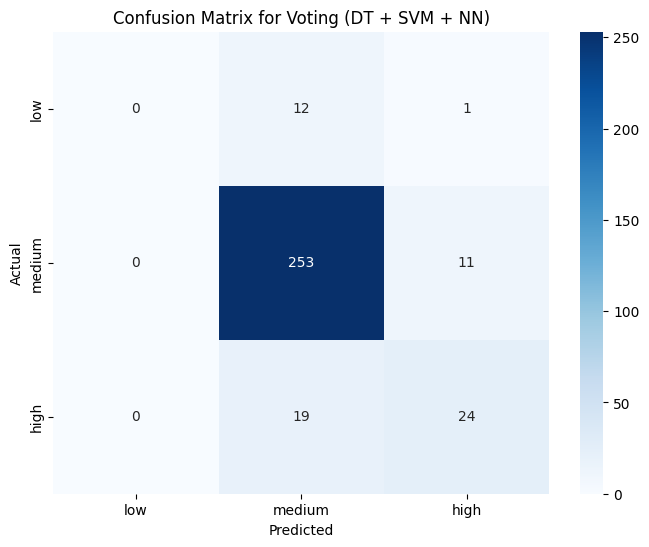

In [19]:
# 6. Voting Classifier (DT, SVM, NN)
print("\n--- Evaluating Model 2: Voting (DT + SVM + NN) ---")
if df is not None:
    # Define the base estimators
    voting1 = VotingClassifier(
        estimators=[
            ("DT", DecisionTreeClassifier(random_state=RANDOM_STATE)),
            ("SVM", SVC(probability=True, random_state=RANDOM_STATE)),
            ("NN", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=RANDOM_STATE)),
        ],
        voting="soft",  # Use soft voting for weighted average of probabilities
    )
    
    evaluate_model(
        "Voting (DT + SVM + NN)", voting1, x_train, y_train, x_test, y_test, results
    )

## Section 6. Compare Results
We organize the results into a pandas DataFrame. As recommended in the instructions, we calculate the gap between Train and Test performance for both Accuracy and F1 Score. A smaller gap indicates better generalization (less overfitting) . The table is sorted by Test Accuracy to quickly identify the best models.

In [20]:
if df is not None and results:
    # Create a table of results
    results_df = pd.DataFrame(results)
    
    # Calculate the gaps (overfitting/underfitting indication)
    results_df["Accuracy Gap"] = results_df["Train Accuracy"] - results_df["Test Accuracy"]
    results_df["F1 Gap"] = results_df["Train F1"] - results_df["Test F1"]
    
    # Format and sort the table
    results_df = results_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
    
    # Reorder columns for presentation
    results_df = results_df[[
        "Model", 
        "Train Accuracy", "Test Accuracy", "Accuracy Gap", 
        "Train F1", "Test F1", "F1 Gap"
    ]]

    print("\nSummary of All Models:")
    print(results_df)
    #print(results_df.to_markdown(index=False, floatfmt=".4f"))


Summary of All Models:
                    Model  Train Accuracy  Test Accuracy  Accuracy Gap  \
0     Random Forest (100)        1.000000       0.887500      0.112500   
1  Voting (DT + SVM + NN)        0.922596       0.865625      0.056971   

   Train F1   Test F1    F1 Gap  
0   1.00000  0.866056  0.133944  
1   0.90606  0.843416  0.062644  


### Section 6.1 - Visual Comparison of Models

To better visualize the performance differences, we can create bar plots comparing the key metrics. The first plot shows the **Test Accuracy and Test F1 Score** for each model, giving a clear view of their predictive power. The second plot visualizes the **Accuracy and F1 Gaps**, which helps in assessing the degree of overfitting.

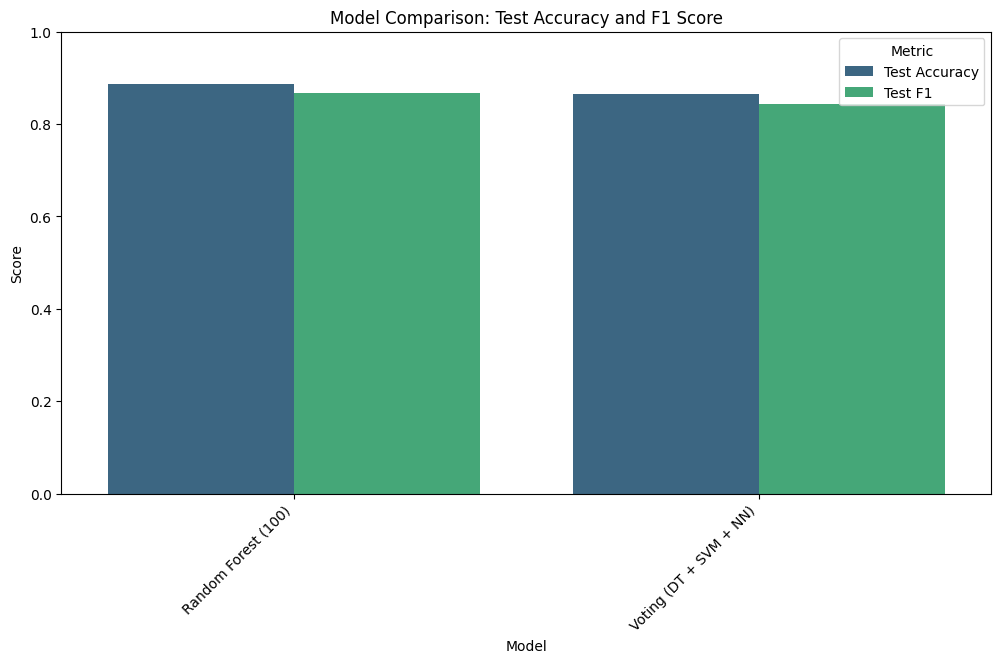

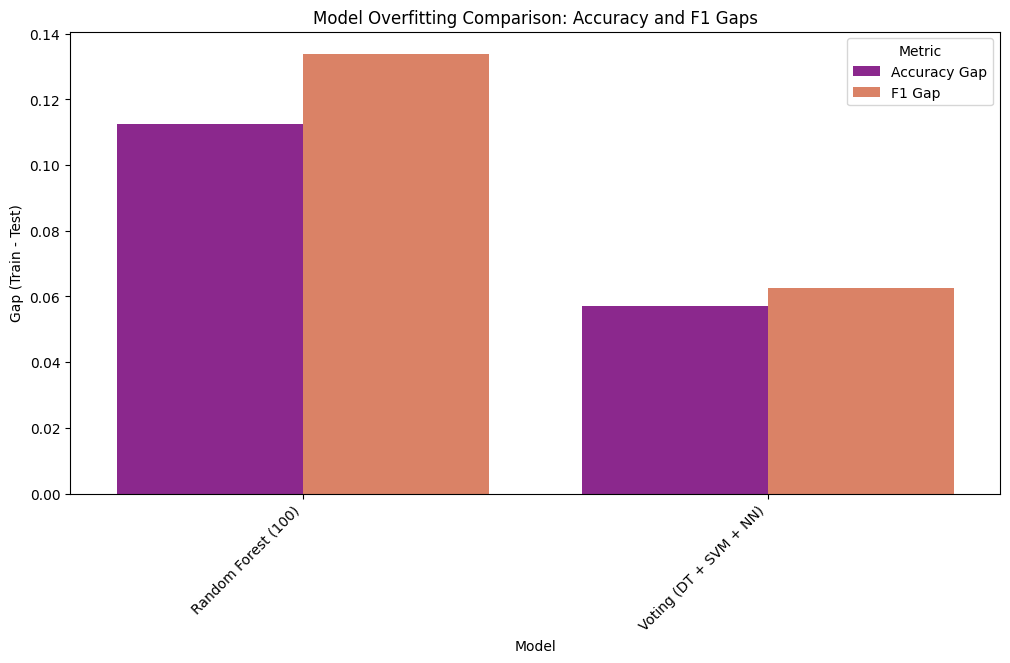

In [21]:
if df is not None and results:
    # Plot for Test Accuracy and Test F1 Score
    plt.figure(figsize=(12, 6))
    results_melted = results_df.melt(id_vars='Model', value_vars=['Test Accuracy', 'Test F1'], var_name='Metric', value_name='Score')
    sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted, palette='viridis')
    plt.title('Model Comparison: Test Accuracy and F1 Score')
    plt.ylabel('Score')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # Plot for Accuracy and F1 Gaps
    plt.figure(figsize=(12, 6))
    gap_melted = results_df.melt(id_vars='Model', value_vars=['Accuracy Gap', 'F1 Gap'], var_name='Metric', value_name='Gap')
    sns.barplot(x='Model', y='Gap', hue='Metric', data=gap_melted, palette='plasma')
    plt.title('Model Overfitting Comparison: Accuracy and F1 Gaps')
    plt.ylabel('Gap (Train - Test)')
    plt.xticks(rotation=45, ha='right')
    plt.show()